In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

from PIL import Image

In [3]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인
from importlib.metadata import version
import cv2
import pixellib


print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


In [3]:
os.getcwd()

'/aiffel/aiffel/review/Aiffel_Quest/QUEST10'

## Step1. 인물모드 직접해보기

(500, 892, 3)


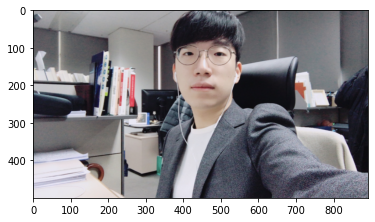

In [4]:
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig1 = cv2.imread(img_path1) 

print(img_orig1.shape)
# (500, 892, 3)

plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

### Deeplab 불러오기, 잘 호출되는지 확인용

In [5]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ff3f3263370>)

### model호출, 3개사진동안 계속 사용할 것임

In [6]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

#### (1) 예시사진

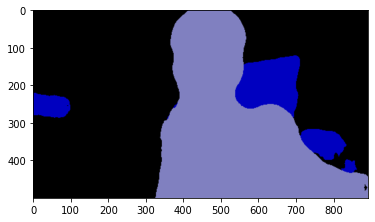

{'class_ids': array([ 0,  9, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])}


In [7]:
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
segvalues1, output1 = model.segmentAsPascalvoc(img_path1)


#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output1)
plt.show()


# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
print(segvalues1)

### LABEL_NAMES 잘 출력되는지 확인용

In [8]:
LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
print(len(LABEL_NAMES))

21


In [9]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues1['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

(500, 892)


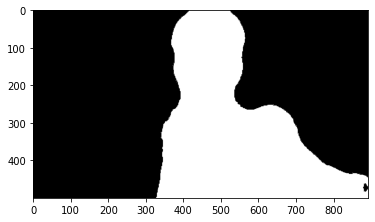

In [11]:
# 컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
colormap[15]
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map1 = np.all(output1==seg_color, axis=-1) 
print(seg_map1.shape) 
plt.imshow(seg_map1, cmap='gray')
plt.show()

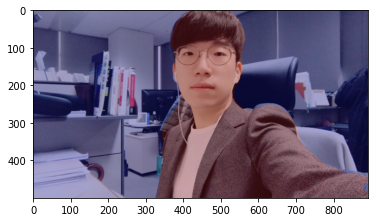

In [12]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show1 = img_orig1.copy()
# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_true1 = seg_map1.astype(np.uint8) * 255
img_mask_false1 = seg_map1.astype(np.uint8) * 0
# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask1 = cv2.applyColorMap(img_mask_true1, cv2.COLORMAP_JET)
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show1 = cv2.addWeighted(img_show1, 0.7, color_mask1, 0.3, 0.0)
plt.imshow(cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB))
plt.show()

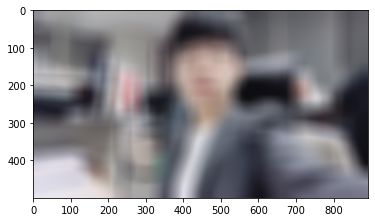

In [13]:
img_orig_blur1 = cv2.blur(img_orig1, (50,50))   # (13,13)은 blurring kernel, 변경 가능
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur1, cv2.COLOR_BGR2RGB))
plt.show()

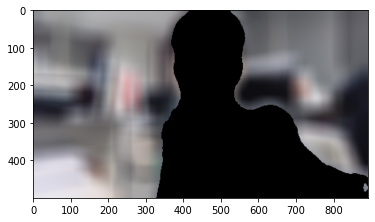

In [14]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color1 = cv2.cvtColor(img_mask_true1, cv2.COLOR_GRAY2BGR)
# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask1 = cv2.bitwise_not(img_mask_color1)
# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur1 = cv2.bitwise_and(img_orig_blur1, img_bg_mask1)
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))
plt.show()

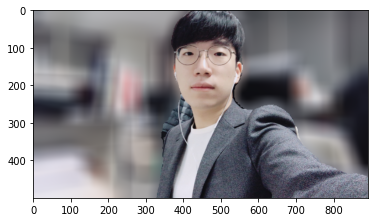

In [15]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat1 = np.where(img_mask_color1==255, img_orig1, img_bg_blur1)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.show()

#### (2) 개인 사진

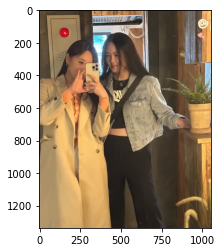

In [16]:
img_path2 = './me.jpg'  
img_orig2 = cv2.imread(img_path2) 

# (1337, 1057, 3)

plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

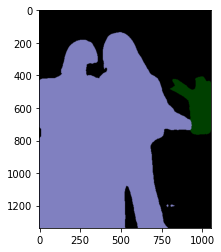

background
person
pottedplant


In [17]:
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output2)
plt.show()

# segvalues2


#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

(1337, 1057)


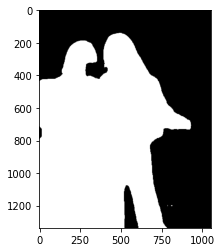

In [18]:
seg_map2 = np.all(output2==seg_color, axis=-1) 
print(seg_map2.shape) 
plt.imshow(seg_map2, cmap='gray')
plt.show()

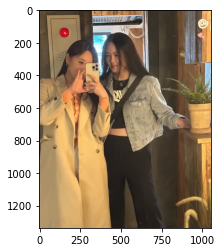

In [19]:
img_show2 = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_true2 = seg_map2.astype(np.uint8) * 255
img_mask_false2 = seg_map2.astype(np.uint8) * 0

color_mask = cv2.applyColorMap(img_mask_true2, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show2, 0.7, color_mask, 0.3, 0.0)
plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

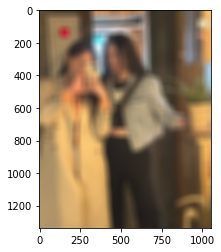

In [20]:
# (13,13)은 blurring kernel, 변경 가능
img_orig_blur2 = cv2.blur(img_orig2, (50,50)) 
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

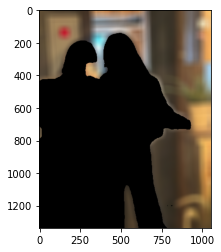

In [21]:
img_mask_color2 = cv2.cvtColor(img_mask_true2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

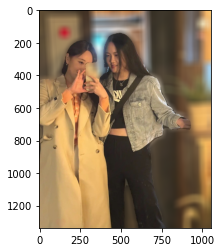

In [22]:
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
img_path22 = './me2.jpg'  
cv2.imwrite(img_path22, img_concat2)

True

#### (3) 고양이 - outfocusing하기

(720, 960, 3)


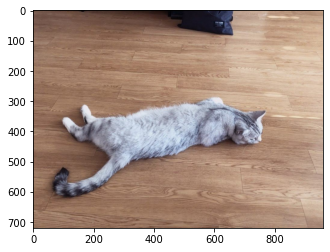

In [24]:
img_path3 = './cat.jpg'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
# (720, 960, 3)

plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

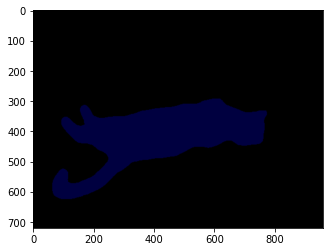

background
cat


In [25]:
segvalues3, output3 = model.segmentAsPascalvoc(img_path3)
plt.imshow(output3)
plt.show()

# segvalues3

for class_id in segvalues3['class_ids']:
    print(LABEL_NAMES[class_id])

In [26]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# print(colormap[:20]) #생성한 20개의 컬러맵 출력


# 컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
print(colormap[8])  # [64 0 0]


# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color = (0, 0, 64)

[64  0  0]


(720, 960)


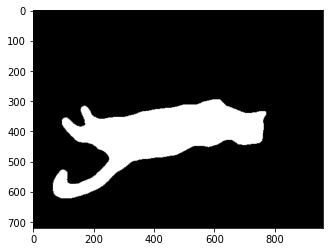

In [27]:
seg_map3 = np.all(output3==seg_color, axis=-1) 
print(seg_map3.shape) 
plt.imshow(seg_map3, cmap='gray')
plt.show()

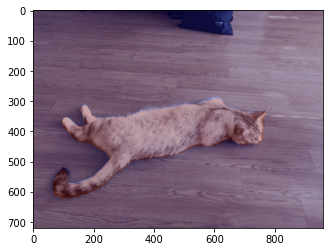

In [28]:
img_show3 = img_orig3.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_true3 = seg_map3.astype(np.uint8) * 255
img_mask_false3 = seg_map3.astype(np.uint8) * 0

color_mask = cv2.applyColorMap(img_mask_true3, cv2.COLORMAP_JET)

img_show3 = cv2.addWeighted(img_show3, 0.7, color_mask, 0.3, 0.0)
plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

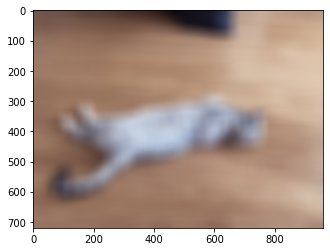

In [29]:
# (13,13)은 blurring kernel, 변경 가능
img_orig_blur3 = cv2.blur(img_orig3, (50,50)) 
plt.imshow(cv2.cvtColor(img_orig_blur3, cv2.COLOR_BGR2RGB))
plt.show()

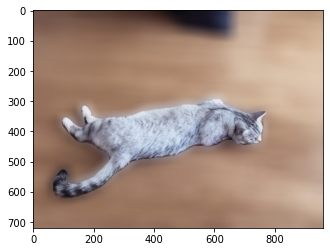

In [30]:
img_mask_color3 = cv2.cvtColor(img_mask_true3, cv2.COLOR_GRAY2BGR)
img_bg_mask3 = cv2.bitwise_not(img_mask_color3)
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask3)
# plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
# plt.show()

img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경바꾸기

(720, 550, 3)


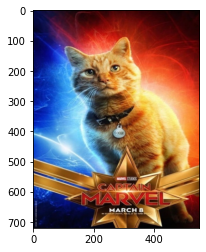

In [31]:
img_path4 = './CaptainGoose.jpg'  
img_orig4 = cv2.imread(img_path4) 

print(img_orig4.shape)
# (1337, 1057, 3)

plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
# img_resize = img_orig4.resize((720, 960))
# print(img_resize.shape)
# # image_resize = img_resize.size
# # print(image_resize.shape)

# plt.imshow(cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB))
# plt.show()

In [33]:
#img_resize = cv2.resize(img_orig4, dsize=(0, 0), fx = img_orig3.shape[0] / img_orig4.shape[0], fy = img_orig3.shape[0])
#plt.imshow(img_resize)
#print(img_resize.shape)

In [34]:
img_path = './cat.jpg'
bg_path = './CaptainGoose.jpg'

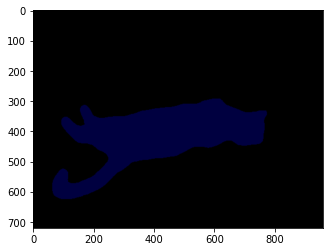

In [35]:
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()

In [36]:
color_map = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

(720, 960)


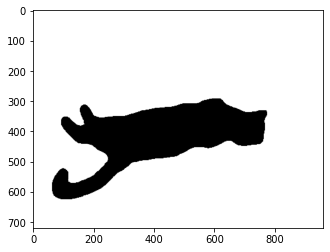

In [37]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
index = LABEL_NAMES.index('cat')

seg_color = (color_map[index][2], color_map[index][1], color_map[index][0])
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

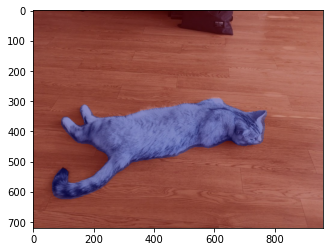

In [40]:
img_orig = cv2.imread(img_path) 
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_origin

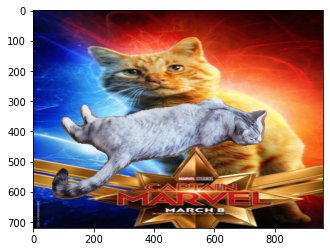

In [42]:
img_bg = cv2.imread(bg_path)
resized_img_bg = cv2.resize(img_bg, (img_mask_color.shape[1], img_mask_color.shape[0]))

img_concat = np.where(img_mask_color == 255, resized_img_bg, img_orig)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
segvalues4, output4 = model.segmentAsPascalvoc(img_path4)
plt.imshow(output4)
plt.show()

# segvalues4

for class_id in segvalues3['class_ids']:
    print(LABEL_NAMES[class_id])

In [ ]:
seg_map4 = np.all(output4==seg_color, axis=-1) 
print(seg_map4.shape) 
# plt.imshow(seg_map4, cmap='gray')
# plt.show()

In [ ]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# print(colormap[:20]) #생성한 20개의 컬러맵 출력


# 컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
print(colormap[8])  # [64 0 0]


# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color = (0, 0, 64)




In [ ]:
img_show4 = img_orig4.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_true4 = seg_map4.astype(np.uint8) * 255

color_mask4 = cv2.applyColorMap(img_mask_true4, cv2.COLORMAP_JET)

# img_show4 = cv2.addWeighted(img_show4, 0.7, color_mask4, 0.3, 0.0)
# plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
# plt.show()


img_mask4 = seg_map4.astype(np.uint8) * 255
img_mask_color4 = cv2.cvtColor(img_mask4, cv2.COLOR_GRAY2BGR)
# img_concat4 = np.where(img_mask_color4==255, img_orig4, img_bg_blur3)



img_concat4 = np.where(img_mask_color3==255, img_resize2,output4)
plt.imshow(cv2.cvtColor(img_concat4, cv2.COLOR_BGR2RGB))
plt.show()

# plt.imshow(img_concat4)
 

## Step2. 사진에서 문제점 찾기

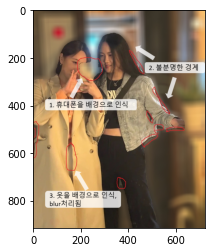

In [4]:
img_path23 = os.getenv('HOME')+'/aiffel/workplace/Aiffel_Quest/QUEST10/me3.png'  
img_orig23 = cv2.imread(img_path23) 
# img_orig23.resize(720, 960)
plt.imshow(cv2.cvtColor(img_orig23, cv2.COLOR_BGR2RGB))
img_resize23 = img_orig23.resize((1000, 1500))
plt.show()

1. 휴대폰을 배경으로 인식 <br>
2. 머리카락, 옷 테두리의 불분명한 경계 <br> 
3. 옷을 배경으로 인식해서 blur 처리함 <br>

## Step3. 해결방법을 제안해 보기

1. 핸드폰을 사람으로 인식:
    - label_names에는 휴대폰이란느 라벨이 없는 것을 확인했다. 그렇다고 모든 물체들을 다 라벨링 할 수 없고, 특히 업로드 한 사진에서 사람이 핸드폰을 들고 있는 것을 확인 할 수 있듯이, 손끝에 닿은 물건마저 사람이라고 인식시키면 될 거 같다. 이때는 대상의 중심을 핸드폰으로 두고, 핸드폰 자체를 사람이라고 인식하면 해결 할 수 있지 않을까?  <br> <br>

2. 불분명한 경계:
    - 사진에서 보면 경계부분이 사진포토샵에서 누끼를 따듯이 자연스럽지는 않다. 배경부분이 일부 덜 blur처리 되었다. 생각해본 방법으로는 segmentation으로 검출된 대상에서 전처리 또는 후처리를 할 때 이미지의 윤곽만 먼저 가져오고, 가장자리는 차라리 블러처리를 해버리면 포토샵에서 누끼를 따오듯이 검출하려는 대상만 정확히 blur 처리가 되지 않고 뚜렷해지지 않을까? <br> <br>

3. 옷을 배경으로 인식:
    - 왜 옷을 blur처리 했는지 도저히 모르겠다..... 이 부분은 2번과 반대로, segmentation을 해올 때 그 반대로, 검출대상이라고 인식이 되어진 것들을 blur 처리를 하지 않으면.. 가능하려나..? <br> <br>

### 자동화하기, 사진 불러오는 함수

#### (1) 예시 사진

In [ ]:
# 함수는 3장의 사진출력때 모두 동일하게 쓸것임

def show_img(img_path):
    img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    return img_rgb


img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'
img_rgb1 = show_img(img_path1)
print(img_rgb1.shape)

### Semantic_Segmentation_사람과 배경 분리하기

In [ ]:
def image_segmentation(img_path, img_rgb):
    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]
    
    # PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
    model = semantic_segmentation()
    model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
    model.load_pascalvoc_model(model_file)
    segvalues, output1 = model.segmentAsPascalvoc(img_path1)  # 다른 사진 호출할때는 파라미터명 변경
    
#     print(segvalues)
    
    #segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
    
    
    #segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
    return plt.imshow(output1) # 다른 사진 호출할때는 파라미터명 변경


output1 = image_segmentation(os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png', img_rgb1) # 다른 사진 호출할때는 파라미터명 변경
output1